## Contents
* [1. Improved Model](#1.-Improved-Model)
* [2. Imports](#2.-Imports)
* [3. Data Cleaning & Preparation](#3.-Data-Cleaning-&-Preparation)
* [4. Model Fit & Predict](#4.-Model-Fit-&-Predict)
    * [4.1 Model 2](#4.1-Model-2)
    * [4.2 Model 3](#4.2-Model-3)
    * [4.3 Model 4](#4.3-Model-4)
* [5. Remarks](#5.-Remarks)

---
## 1. Improved Model
---
Objective: to compare the weighted-average ROC AUC scores and f1-scores (kf, lca) of the following models:

|                                     | Model 1<br>(from notebook 3) | Model 2       | Model 3  | Model 4 |
|-------------------------------------|----------------------------|---------------|----------|---------|
| Vectoriser                          | TFIDF                      | TFIDF         | TFIDF    | TFIDF   |
| Model                               | Multinomial Naive Bayes    | Random Forest | XGBoost | SVM     |

Note: the code below was ran on Kaggle, to make use of Kaggle GPUs.

---
## 2. Imports
---

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier as ovr

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, roc_auc_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

---
## 3. Data Cleaning & Preparation
---

- read CSV files

In [2]:
kf_df = pd.read_csv('/kaggle/input/sq-services/kf_clean.csv')
lca_df = pd.read_csv('/kaggle/input/sq-services/LCA_clean.csv')
other_df = pd.read_csv('/kaggle/input/sq-services/other_clean.csv')
kf_df.head()

,text,source
0,Qualifying as EG for the first time,kf
1,Which FFP for me? Master Discussion,kf
2,#SQMelbourneTram,kf
3,Advice sought - Changing redemption bookings,kf
4,First Savers SYD-SIN,kf


- find and resolve NA values

In [3]:
services_df = pd.concat([kf_df, lca_df, other_df])

print(services_df.isna().sum())

# acceptable to drop 3 NA values out of 44k values
services_df.dropna(inplace=True)
# reset index, and drop old index
services_df.reset_index(drop=True, inplace=True)

print(services_df.isna().sum())

text      3
source    0
dtype: int64
text      0
source    0
dtype: int64


- create a 'kf' column: 
    - if value = 0, the source is others
    - if value = 1, the source is kf
    - if value = 2, the source is from LCA

In [4]:
services_df['y_true'] = services_df['source'].map({'other':0, 'kf': 1, 'lca': 2})
services_df['y_true'].value_counts(normalize=True)

1    0.402724
0    0.353570
2    0.243706
Name: y_true, dtype: float64

---
## 4. Model Fit & Predict
---

## 4.1 Model 2
### - Random Forest

- train-test-split our df

In [5]:
X = services_df['text']
y = services_df['y_true']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train

13477    Does KF actually explain the differences in qu...
29195    BKK airport closed: SQ et al Cancel flights 26...
22061    Originally posted by SQ LPPView PostThat's a v...
6624     Originally posted by GLAM82View PostIs there a...
20643    I would have thought they will use the SKL, sa...
                               ...                        
12020    Originally posted by CGKView Post SQ prefers I...
43382    I thought I'd get your views on this, which is...
1598     Originally posted by florianwagnerView PostSo ...
11541             letter dated 19 March received 28 March.
22264    Sorry to report that as I got to SFO airport f...
Name: text, Length: 33095, dtype: object

- create pipeline for GridSearchCV later

In [31]:
pipe_rf = make_pipeline(
    TfidfVectorizer(),
    rfc(random_state=42)
)
pipe_rf.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'randomforestclassifier': RandomForestClassifier(random_state=42),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer':

In [32]:
pipe_rf_params = {'tfidfvectorizer__max_features': [None,300,500],
                  'tfidfvectorizer__stop_words': [None,'english'],
                  'randomforestclassifier__max_depth': [5,10],
                  'randomforestclassifier__min_samples_leaf': [3,5],
                  'randomforestclassifier__ccp_alpha': [0,0.5,1]
                 }

- GridSearchCV

In [33]:
pipe_rf_gs = GridSearchCV(pipe_rf, pipe_rf_params)
pipe_rf_gs.fit(X_train, y_train)
print(pipe_rf_gs.best_estimator_)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=500)),

                ('randomforestclassifier',

                 RandomForestClassifier(ccp_alpha=0, max_depth=10,

                                        min_samples_leaf=3, random_state=42))])


- visualise confusion matrix

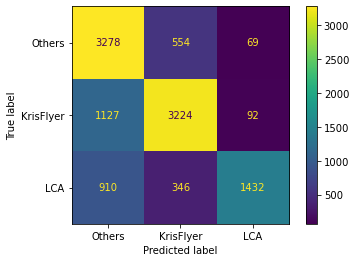

In [34]:
y_pred = pipe_rf_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [35]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support



           0       0.62      0.84      0.71      3901

           1       0.78      0.73      0.75      4443

           2       0.90      0.53      0.67      2688



    accuracy                           0.72     11032

   macro avg       0.77      0.70      0.71     11032

weighted avg       0.75      0.72      0.72     11032




- display the weighted average ROC AUC score

In [36]:
y_pred_prob = pipe_rf_gs.predict_proba(X_test)
roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

0.8716501105650858

- weighted f1-score of KrisFlyer and LCA

In [37]:
f1_score(y_test, y_pred, labels=[1,2], average = 'weighted')

0.7211229091599115

## 4.2 Model 3
### - XGBoost

- create pipeline for GridSearchCV later

In [38]:
pipe_xgb = make_pipeline(
    TfidfVectorizer(),
    XGBClassifier(seed=42)
)
pipe_xgb.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, gamma=None,
                 gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                 max_leaves=None, min_child_weight=None, missing=nan,
                 monotone_constraints=None, n_estimators=100, n_jobs=None,
                 num_parallel_tree=None, predictor=None, random_state=None,
                 reg_alpha=None, reg_lambda=None, ...))],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'xgbclassifier': XGBClassifier(base_score=None, booster=None, callbacks=None

- pick xgb params based on [XGBoost fine tuning](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663), limited by time spent on training

In [39]:
pipe_xgb_params = {'tfidfvectorizer__max_features': [300,500],
                   'tfidfvectorizer__stop_words': [None,'english'],
                   'xgbclassifier__max_depth': [3,6],
                   'xgbclassifier__n_estimators': [100,200]
                  }

- GridSearchCV

In [40]:
pipe_xgb_gs = GridSearchCV(pipe_xgb, pipe_xgb_params)
pipe_xgb_gs.fit(X_train, y_train)
print(pipe_xgb_gs.best_estimator_)

Pipeline(steps=[('tfidfvectorizer',

                 TfidfVectorizer(max_features=500, stop_words='english')),

                ('xgbclassifier',

                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,

                               colsample_bylevel=1, colsample_bynode=1,

                               colsample_bytree=1, early_stopping_rounds=None,

                               enable_categorical=False, eval_metric=None,

                               gamma=0, gpu_id=-1, grow_policy='depthwise',

                               importance_type=None, interaction_constraints='',

                               learning_rate=0.300000012, max_bin=256,

                               max_cat_to_onehot=4, max_delta_step=0,

                               max_depth=6, max_leaves=0, min_child_weight=1,

                               missing=nan, monotone_constraints='()',

                               n_estimators=200, n_jobs=0, num_parallel_tree=1,

       

- visualise confusion matrix

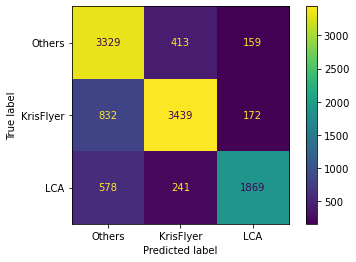

In [41]:
y_pred = pipe_xgb_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [42]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support



           0       0.70      0.85      0.77      3901

           1       0.84      0.77      0.81      4443

           2       0.85      0.70      0.76      2688



    accuracy                           0.78     11032

   macro avg       0.80      0.77      0.78     11032

weighted avg       0.79      0.78      0.78     11032




- display the weighted average ROC AUC score

In [43]:
y_pred_prob = pipe_xgb_gs.predict_proba(X_test)
roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

0.9133715161339281

- weighted f1-score of KrisFlyer and LCA

In [44]:
f1_score(y_test, y_pred, labels=[1,2], average = 'weighted')

0.7902962806318224

## 4.3 Model 4
### - SVM

- create pipeline for GridSearchCV later

In [45]:
pipe_svm = make_pipeline(
    TfidfVectorizer(),
    SVC(random_state=42)
)
pipe_svm.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('svc', SVC(random_state=42))],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'svc': SVC(random_state=42),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tfidfvectorizer__vocabulary': No

In [57]:
pipe_svm_params = {'tfidfvectorizer__max_features': [300,500],
                   'tfidfvectorizer__stop_words': [None,'english'],
                   'svc__C': [0.1,1],
                   'svc__gamma': [1,0.1]
                  }

- GridSearchCV

In [51]:
pipe_svm_gs = GridSearchCV(pipe_svm, pipe_svm_params)
pipe_svm_gs.fit(X_train, y_train)
print(pipe_svm_gs.best_estimator_)

Pipeline(steps=[('tfidfvectorizer',

                 TfidfVectorizer(max_features=500, stop_words='english')),

                ('svc', SVC(C=1, gamma=1, random_state=42))])


- train the best SVM estimator, with 'probability' parameter as True
- this is done separately from GridSearchCV above, as the SVM algo will conduct a 5-fold cross-validation and slow down significantly
- with 'probability' parameter = True, I can use predict_proba later to derive the ROC AUC score

In [10]:
# create another SVM pipe with the best params
pipe_svm_best = make_pipeline(
    TfidfVectorizer(max_features=500, stop_words='english'),
    SVC(C=1, gamma=1,probability=True, random_state=42)
)

In [11]:
pipe_svm_best.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=500, stop_words='english')),
                ('svc', SVC(C=1, gamma=1, probability=True, random_state=42))])

- visualise confusion matrix

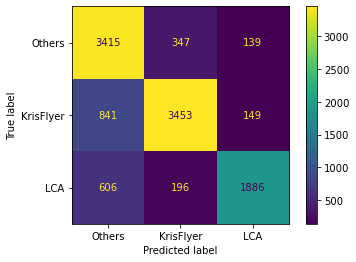

In [14]:
y_pred = pipe_svm_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [15]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support

           0       0.70      0.88      0.78      3901
           1       0.86      0.78      0.82      4443
           2       0.87      0.70      0.78      2688

    accuracy                           0.79     11032
   macro avg       0.81      0.78      0.79     11032
weighted avg       0.81      0.79      0.79     11032



- display the weighted average ROC AUC score

In [12]:
y_pred_prob = pipe_svm_best.predict_proba(X_test)
roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

0.9134609880735225

- weighted f1-score of KrisFlyer and LCA

In [16]:
f1_score(y_test, y_pred, labels=[1,2], average = 'weighted')

0.8023115332819044

---
## 5. Remarks
---

|                                     | Model 1<br>(from notebook 3) | Model 2       | Model 3  | Model 4<br>\*Best performance\* |
|-------------------------------------|----------------------------|---------------|----------|---------|
| Vectoriser                          | TFIDF                      | TFIDF         | TFIDF    | TFIDF   |
| Model                               | Multinomial Naive Bayes    | Random Forest | XGBoost | SVM     |
| Weighted-average ROC AUC            | 0.889                      | 0.872         | 0.913    | 0.913   |
| Weighted-average f1-score (kf, lca) | 0.748                      | 0.721         | 0.790    | 0.802    |

- Model 3 performed the best with the following params:
    - TfidfVectorizer(max_features=500, stop_words='english')
    - SVC(C=1, gamma=1, probability=True, random_state=42)
<br>
<br>
- although model 3 and model 4 have the similar weighted-average ROC AUC score, model 3 edged out in its weighted-average f1-score. This meant that model 3 has the least false-positive and false-negative prediction for KF and LCA, which is important to the business